In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
import numpy as np

In [4]:
## нормализация линий по возрасту и вычитание тренда литосферного остывания
from scipy import signal
import math
print(mag_ano.name.value_counts().sort_index().index)
chrons= dict(zip(mag_ano.name.value_counts().sort_index().index, [978,1972,3315,4014,4343,4572,4734,4934,5398]))

def make_normalised_line(name):
    one_line=result[result['line']==name]
    chrons_on_line=one_line[one_line['name'].notnull()].name.values
    if chrons[chrons_on_line[0]]<chrons[chrons_on_line[-1]]:
        print('reverse!!')
        one_line=one_line.reindex(index=one_line.index[::-1])
        one_line.index=range(len(one_line))
        chrons_on_line=one_line[one_line['name'].notnull()].name.values
    index=one_line[one_line['name'].notnull()].name.index
    min_chron=one_line[one_line['name'].notnull()].index.min()
    max_chron=one_line[one_line['name'].notnull()].index.max()
    one_line=one_line.loc[min_chron:max_chron]
    one_line.index=range(len(one_line))
    index=one_line[one_line['name'].notnull()].name.index
    new_depth=[]
    regression=[]
    space_on_start=5398-chrons[chrons_on_line[0]]
    new_depth.extend([np.NAN for i in range(space_on_start)])
    regression.extend([np.NAN for i in range(space_on_start)])

    print(chrons_on_line,index)
    for i in range(len(index)-1):
        one_step=one_line[index[i]:index[i+1]]
        f=signal.resample(one_step.depth_x,chrons[chrons_on_line[i]]-chrons[chrons_on_line[i+1]])
        new_depth.extend(f)
    model = LinearRegression()
    model.fit(np.arange(len(new_depth)-space_on_start)[:, None], new_depth[space_on_start:])
    regression.extend(model.predict(np.arange(0,len(new_depth)-space_on_start)[:, None]))
    if len(new_depth)<5398:
        space_on_end=len(new_depth)   
        new_depth.extend([np.NAN for i in range(5398-len(new_depth))])
        regression.extend([np.NAN for i in range(5398-len(regression))])
    new_depth=pd.DataFrame(new_depth,columns=['depth'])    
    new_depth['regression']=regression
    new_depth['diff']=new_depth['depth']-new_depth['regression']
    new_depth.loc[range(space_on_start),'diff']=np.NAN
    new_depth.loc[range(space_on_end,5398),'diff']=np.NAN
    plt.figure(figsize=(13,7))
    plt.plot(-new_depth['diff']/2,label='detrended basement topography')
    plt.plot(-new_depth.loc[space_on_start:space_on_end-5]['regression']/2,label='trend line (cooling)')
    plt.plot(-new_depth.loc[space_on_start:space_on_end-5]['depth']/2,label='basement topography')
    plt.ylabel('depth in time (ms)',{'fontsize':14})
    plt.xlabel('normalised age, linear scale (not distance in km!)',{'fontsize':14})
    plt.xticks([5398-chrons[i] for i in chrons_on_line],list(chrons_on_line))
    plt.legend()
    if name=='Arc11006':
        plt.savefig('example.jpg',dpi=450)
    plt.show()
    return(new_depth,model.coef_)
# Функция ресэмплинга, есть встроенная 
# new_depth=[]
# for i in range(chrons[indexes[0]],chrons[indexes[1]]+1):
#     print(i)
#     one_step=one_line[index[0]:index[1]]
#     position=i/(chrons[indexes[1]]+1)*len(one_step)
#     value=one_step.loc[int(math.floor(position)),'depth_x']+(int(math.ceil(position))-int(math.floor(position)))*(position%1)
#     new_depth.append(value)


Index(['C05ny', 'C06no', 'C13ny', 'C16ny', 'C20no', 'C21any', 'C21no', 'C22no',
       'C24no'],
      dtype='object')


In [9]:
# чтение файлов с фундаментом и магнитными аномалиями
data=pd.read_csv('acoustic_basement.dat', sep=' ',usecols=(0,1,2,4),names=('x','y','line','depth'))
mag_ano=pd.read_csv('test.dat',sep=' ',encoding='cp1251',skiprows=range(0,11),usecols=(0,1,2,6),names=('x','y','depth','name'))

## пересечение аномалий и профилей
## если точка аномалии расположена ближе 8 км к профилю, то ближайшей точке на профиле присваивается эта аномалия
for i in mag_ano.index:
    x=mag_ano.loc[i,'x']
    y=mag_ano.loc[i,'y']
    data['x_new']=abs(data.x-x)
    data['y_new']=abs(data.y-y)
    data['dist']=(data['x_new']**2+data['y_new']**2)**0.5
    min_dist=data['dist'].min()
    if min_dist<8000:
        mag_ano.loc[i,'x']=data[data.dist==min_dist]['x'].values[0]
        mag_ano.loc[i,'y']=data[data.dist==min_dist]['y'].values[0]
result=pd.merge(data,mag_ano,left_on=['x','y'],right_on=['x','y'],how='outer')
result=result[['x','y','line','depth_x','name']]
result.dropna(subset=['line'],inplace=True)

##Разделение профиля Arc14_P07 на две части!
# print(result[result.line=='Arc11004'].head(20))
add_part_1=result[result.line=='Arc11004_2']
add_part_2=result[result.line=='Arc11004']
add_part_1.line='Arc11004'
add_part_2=add_part_2.append(add_part_1,ignore_index=True)
add_part_2.index=[add_part_2.index.min()+i for i in range(add_part_2.index.max()-add_part_2.index.min()+1)]
result=result[~result.line.isin(['Arc11004_2','Arc11004'])]
result=result.append(add_part_2)
result.loc[135938:143673,'line']='Arc14_P07west'

result.replace('Arc11005_2','Arc11005',inplace=True)
# print(result[result.line=='Arc11004'].head(20))

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Arc11003
['C24no' 'C21no' 'C21any' 'C20no' 'C13ny'] Int64Index([0, 2653, 3167, 3662, 5710], dtype='int64')


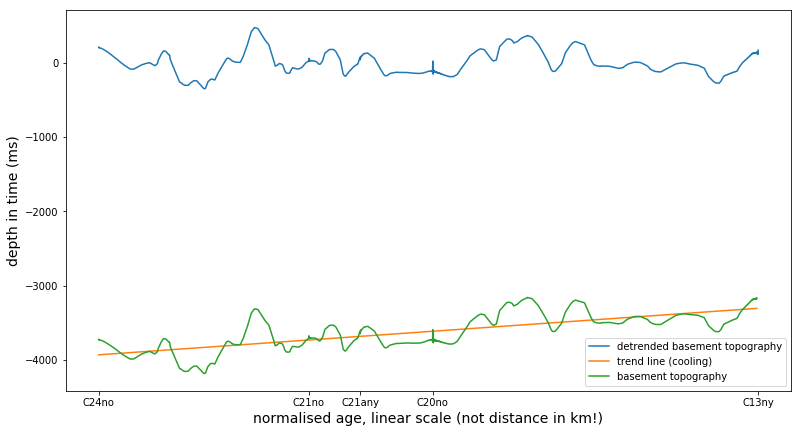

-0.601578422690529
Arc11035
reverse!!
['C21no' 'C20no' 'C16ny'] Int64Index([0, 1724, 2509], dtype='int64')


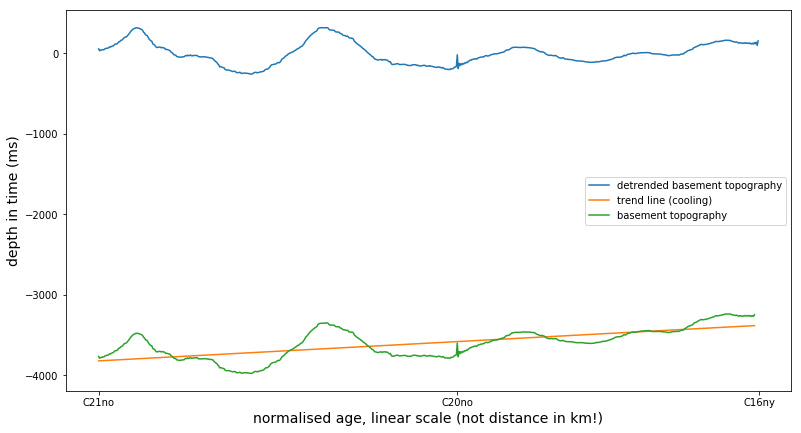

-1.2259436722828578
Arc11005
['C24no' 'C21no' 'C21any' 'C20no' 'C13ny'] Int64Index([0, 2827, 3255, 3798, 5695], dtype='int64')


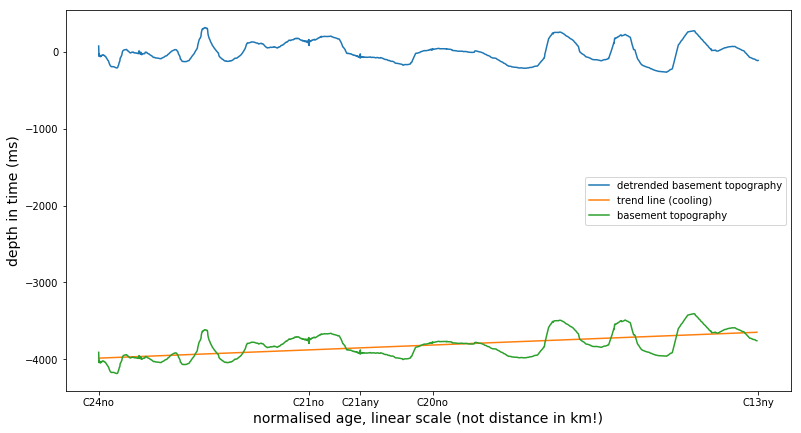

-0.32363576935854566
Arc11006
['C24no' 'C21no' 'C21any' 'C20no' 'C13ny'] Int64Index([0, 2284, 2794, 3403, 5738], dtype='int64')


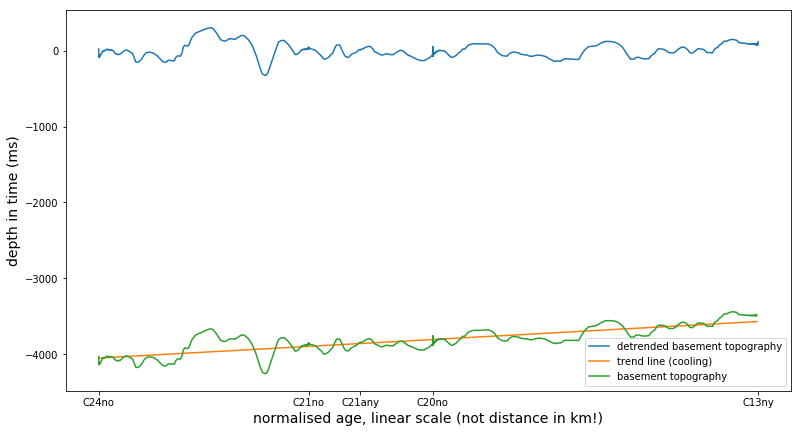

-0.46141973211111426
Arc11006_10
reverse!!
['C20no' 'C13ny' 'C06no' 'C05ny'] Int64Index([0, 2211, 4057, 6327], dtype='int64')


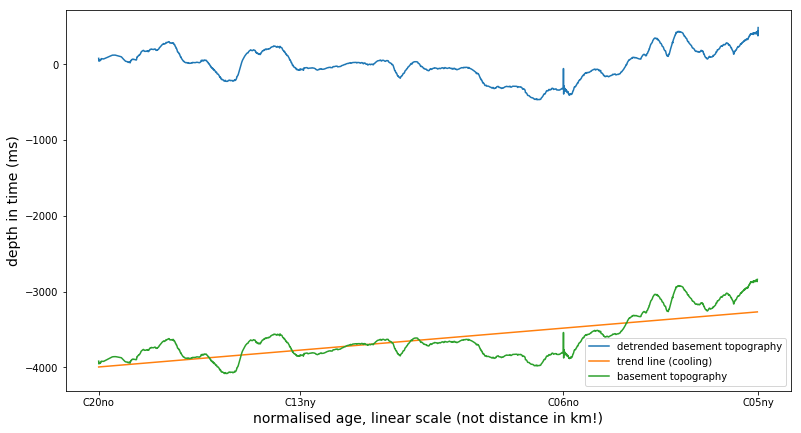

-0.43228247767119504
Arc11024
['C20no' 'C16ny' 'C13ny' 'C06no' 'C05ny'] Int64Index([0, 1208, 1473, 1914, 2282], dtype='int64')


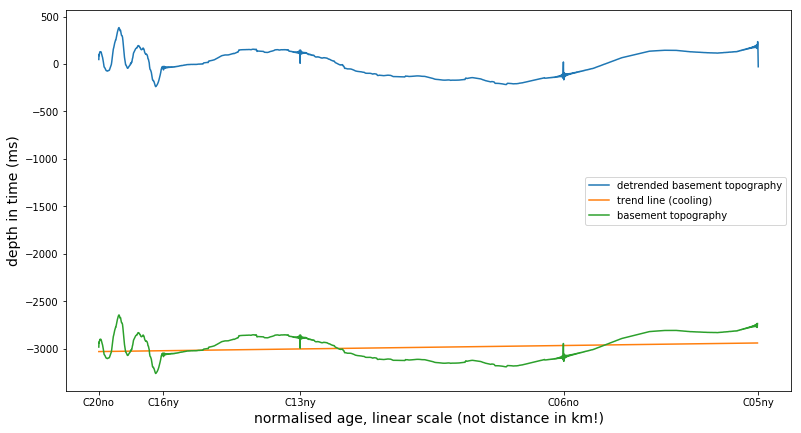

-0.053783853294659754
Arc11027
['C24no' 'C21no' 'C21any' 'C20no' 'C16ny' 'C13ny' 'C06no'] Int64Index([0, 2774, 3149, 3645, 4692, 5052, 5449], dtype='int64')


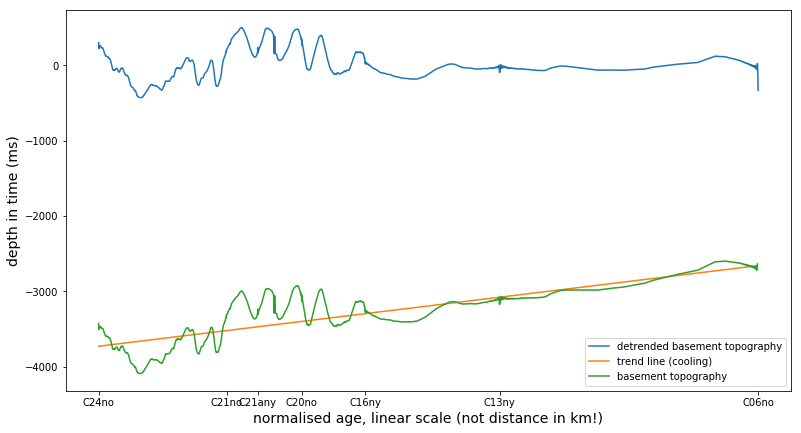

-0.624996766844959
Arc11028
reverse!!
['C21no' 'C21any' 'C20no' 'C16ny' 'C13ny' 'C06no'] Int64Index([0, 478, 975, 2032, 2393, 2801], dtype='int64')


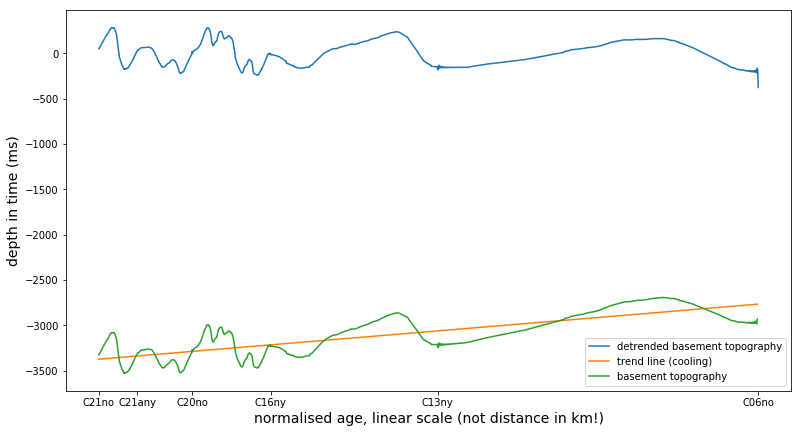

-0.4400780498770995
Arc11029
['C21no' 'C21any' 'C20no' 'C16ny' 'C13ny' 'C06no' 'C05ny'] Int64Index([0, 359, 785, 2078, 2459, 2821, 3567], dtype='int64')


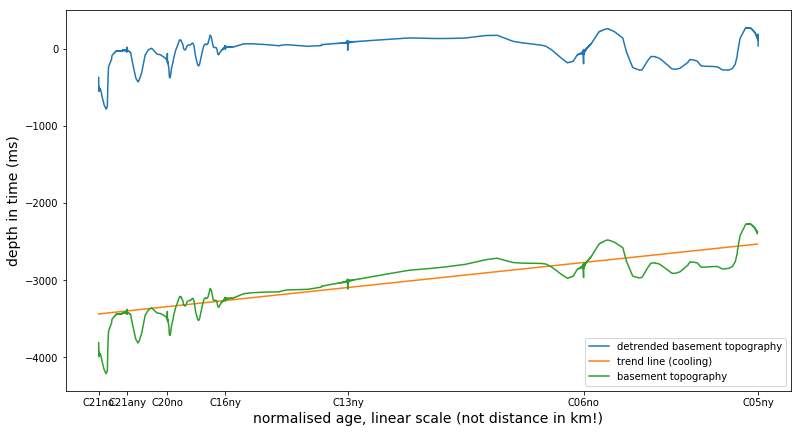

-0.4830845607494074
Arc11030
reverse!!
['C22no' 'C21no' 'C21any' 'C20no' 'C16ny' 'C13ny' 'C06no'] Int64Index([0, 827, 1292, 1912, 3021, 3534, 3955], dtype='int64')


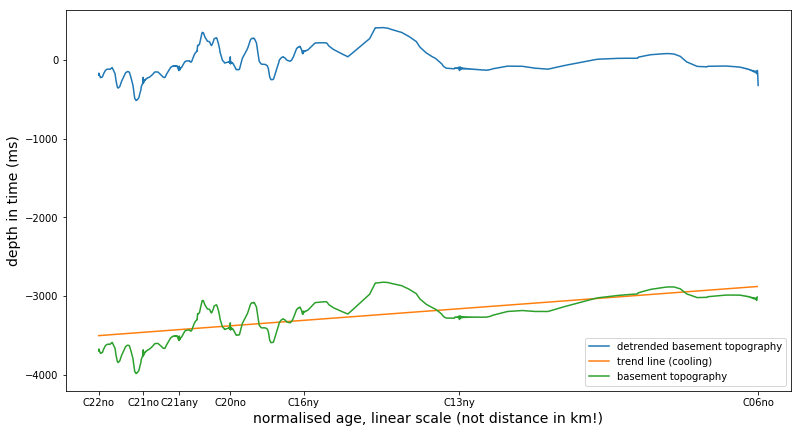

-0.42176119376858723
Arc11031
['C24no' 'C22no' 'C21no' 'C21any' 'C20no' 'C16ny'] Int64Index([0, 2441, 3168, 3516, 4065, 5285], dtype='int64')


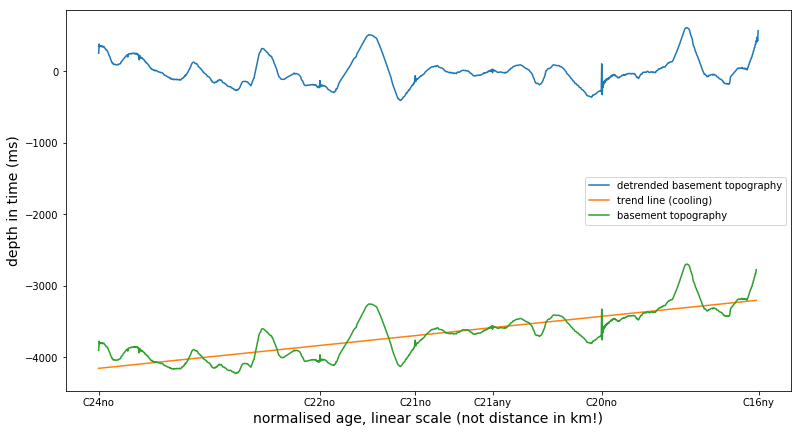

-1.3781859823739382
Arc11032
reverse!!
['C22no' 'C21any' 'C20no' 'C16ny' 'C13ny' 'C06no'] Int64Index([0, 940, 1503, 2969, 3439, 3851], dtype='int64')


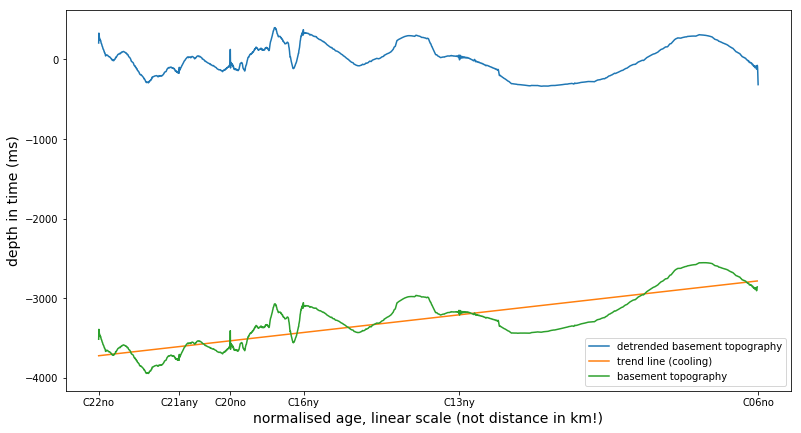

-0.635069200267166
Arc11034
['C22no' 'C21no' 'C21any' 'C16ny' 'C13ny'] Int64Index([0, 540, 1130, 2984, 3347], dtype='int64')


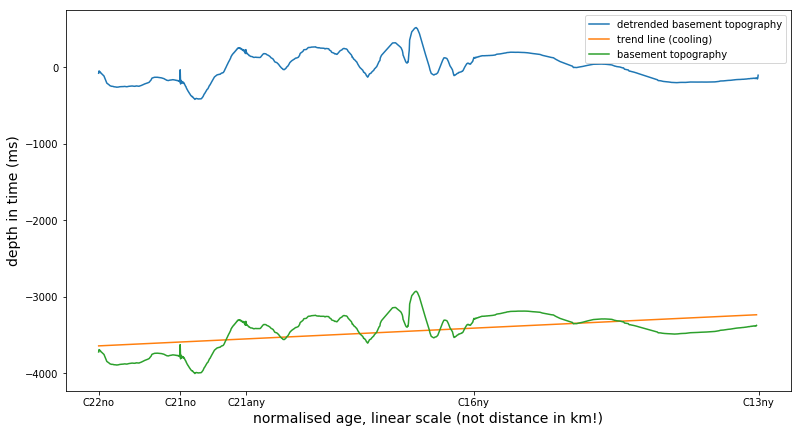

-0.5038678571700805
Arc14_P07
reverse!!
['C24no' 'C21no' 'C13ny' 'C06no' 'C05ny'] Int64Index([0, 2793, 5864, 6607, 7764], dtype='int64')


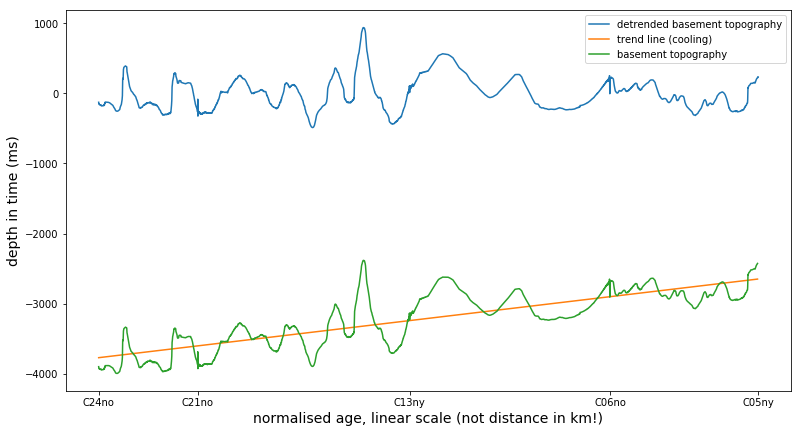

-0.5074843531748537
Arc14_P07west
['C24no' 'C21no' 'C20no' 'C13ny' 'C06no' 'C05ny'] Int64Index([0, 1587, 3283, 5631, 6706, 7734], dtype='int64')


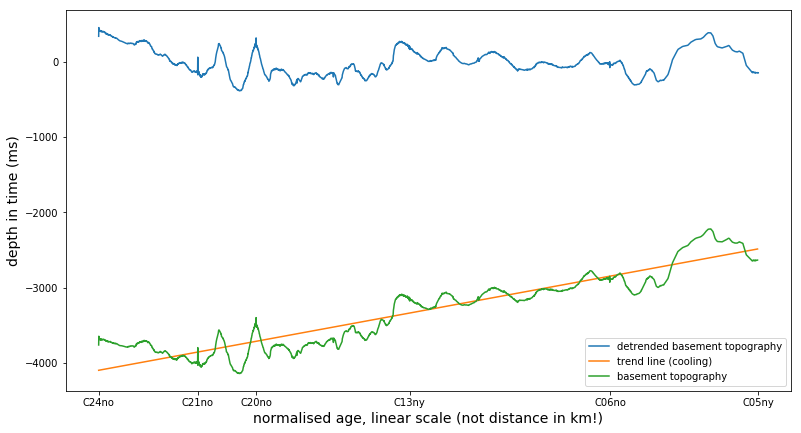

-0.72906235448256
Arc11026
reverse!!
['C21no' 'C20no' 'C16ny' 'C13ny' 'C06no' 'C05ny'] Int64Index([0, 517, 1964, 2290, 2765, 3588], dtype='int64')


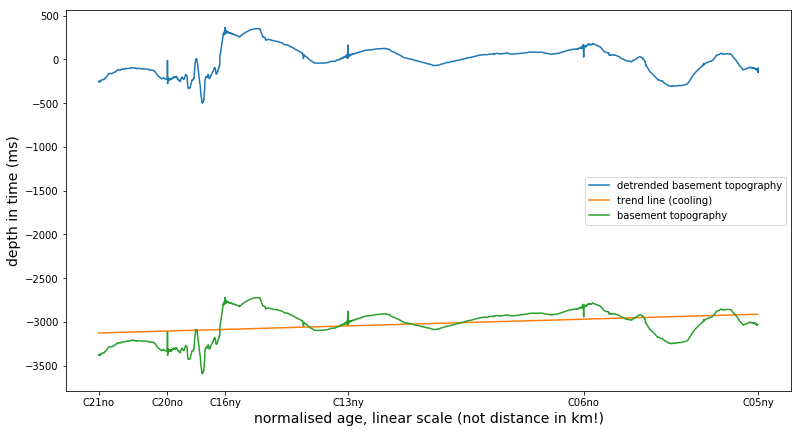

-0.11432629946662151
Arc11004
['C24no' 'C21no' 'C21any' 'C20no' 'C13ny'] Int64Index([0, 3177, 3814, 4251, 6364], dtype='int64')


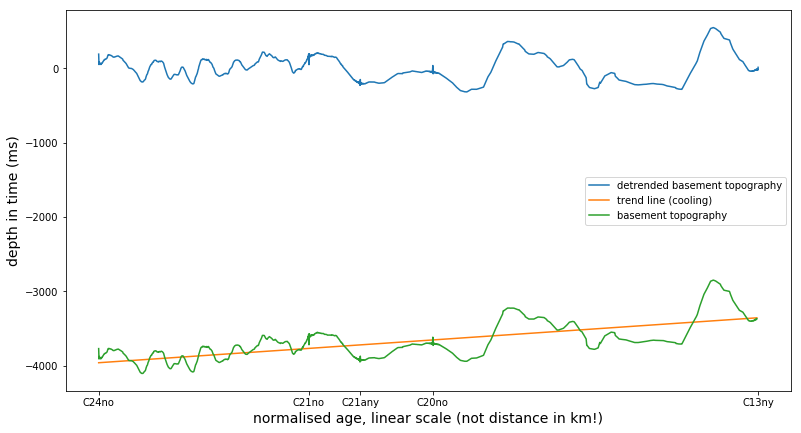

-0.5812961104931791


In [5]:
## Нормализация всех профилей с индексацией по 10000 лет. Каждый индекс - 
## среднее значение фундамента за возрастной интервал 10000 лет
result_DB=pd.DataFrame([np.NAN for i in range(5398)],columns=['res'])
reg_DB=pd.DataFrame([np.NAN for i in range(5398)],columns=['res'])
lines=dict()
for i in result.line.unique():
    if i not in ['Arc11005_04','Arc11006_02','Arc11005_06']:
        print(i)
        df,coef=make_normalised_line(i)
        print(coef[0])
        lines[i]=coef[0]
        result_DB[i]=df['diff']
        reg_DB[i]=df['regression']

In [1176]:
## Разная глупая статистика по нормализованным профилям

result_DB=result_DB.transpose()
mean=result_DB.mean(skipna=True)
median=result_DB.median(skipna=True)
std=result_DB.std(skipna=True)
summ=result_DB.sum(skipna=True)
result_DB=result_DB.transpose()
result_DB['mean']=mean
result_DB['med']=median
result_DB['std']=std
result_DB['summ']=summ

In [6]:
## Вычисление RMS шероховатости фундамента

def calc_roughness(row):
    return(result_DB[int(row['start']):int(row['end'])][i].std())

## подготовка таблицы RMS
a=[5398-i for i in chrons.values()]
a.reverse()
RMS=pd.DataFrame(a,columns=['start'])
RMS['end']=RMS['start'].shift(-1)
RMS.fillna(5398,inplace=True)
## Заполнение таблицы RMS на основе линий в result
for i in result.line.unique():
    if i not in ['Arc11005_04','Arc11006_02','Arc11005_06']:
        RMS[i]=RMS.apply(calc_roughness,axis=1)
RMS['age']=chrons.keys()
RMS['age']=RMS['age'][::-1].values
RMS.drop(8,inplace=True)
RMS

,start,end,Arc11003,Arc11035,Arc11005,Arc11006,Arc11006_10,Arc11024,Arc11027,Arc11028,Arc11029,Arc11030,Arc11031,Arc11032,Arc11034,Arc14_P07,Arc14_P07west,Arc11026,Arc11004,age
0,0,464.0,300.617632,NaN,209.557148,277.464727,NaN,NaN,366.736997,NaN,NaN,NaN,333.088508,NaN,NaN,324.160927,193.726839,NaN,210.762320,C24no
1,464,664.0,419.072003,NaN,75.681552,285.488037,NaN,NaN,262.359842,NaN,NaN,244.743967,587.979591,221.544523,108.830701,351.835555,107.665202,NaN,152.654702,C22no
2,664,826.0,210.059981,315.497973,198.376895,105.803146,NaN,NaN,255.095952,320.934007,571.009095,114.282284,90.328078,117.791746,456.138523,191.494549,282.296672,98.035130,273.464394,C21no
3,826,1055.0,196.814968,355.493851,121.565779,106.585360,NaN,NaN,296.674559,184.570723,263.593190,277.209133,282.378616,126.328524,163.186981,178.222767,392.123682,92.531031,134.097330,C21any
4,1055,1384.0,379.044985,164.435031,192.195065,118.985235,121.994552,305.950942,308.448099,324.777041,234.881630,265.168787,389.614078,304.583696,331.778810,229.449786,235.743173,312.395266,484.517306,C20no
5,1384,2083.0,250.216369,NaN,315.907608,170.289285,301.304269,139.512562,129.148047,257.814782,29.732040,304.918922,NaN,257.693372,289.481573,708.484701,301.687432,275.448101,462.742582,C16ny
6,2083,3426.0,NaN,NaN,NaN,NaN,299.229062,174.286536,110.708003,235.675089,174.680419,132.247122,NaN,433.426108,NaN,483.260863,158.977734,107.651366,NaN,C13ny
7,3426,4420.0,NaN,NaN,NaN,NaN,431.339688,168.507688,NaN,NaN,388.693750,NaN,NaN,NaN,NaN,297.305380,414.511602,281.306413,NaN,C06no


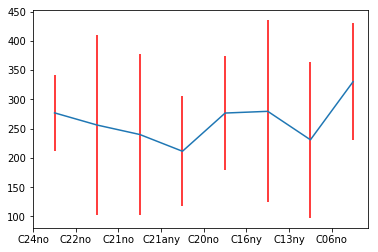

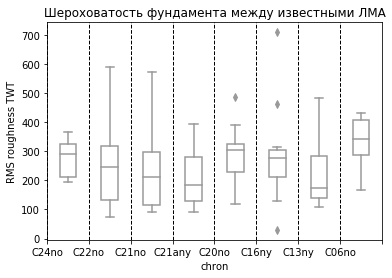

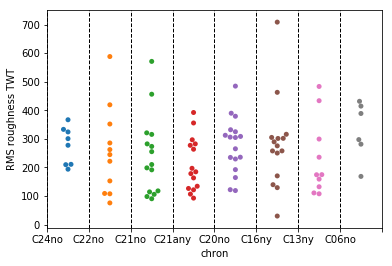

In [7]:
RMS[[i for i in RMS.columns if 'Arc' in i]].std(axis=1)
plt.errorbar(x=[i for i in range(8)],y=RMS[[i for i in RMS.columns if 'Arc' in i]].mean(axis=1),yerr=RMS[[i for i in RMS.columns if 'Arc' in i]].std(axis=1),ecolor='red')
plt.xticks([i-0.5 for i in range(8)],RMS.age)
plt.show()

import seaborn as sns

a=RMS.drop(labels=['start','end','age'],axis=1).unstack()
lines=[i[0] for i in a.index.tolist()]
c=[]
for i in range(17):
    c.extend(list(chrons.keys())[1:])
RMS_for_sns=pd.DataFrame(data=list(zip(lines,list(a.values),c[::-1])),columns=['line','RMS roughness TWT','chron'])

sns.boxplot(data=RMS_for_sns,x='chron',y='RMS roughness TWT',color='white',width=0.4)
plt.xticks([i-0.5 for i in range(9)],RMS.age)
for xc in [i-0.5 for i in range(8)]:
    plt.axvline(x=xc, color='k', linestyle='--',lw=1)
plt.title('Шероховатость фундамента между известными ЛМА')
plt.savefig('RMS_rough.jpg',dpi=450)    
plt.show()
sns.swarmplot(data=RMS_for_sns,x='chron',y='RMS roughness TWT')
plt.xticks([i-0.5 for i in range(9)],RMS.age)
for xc in [i-0.5 for i in range(8)]:
    plt.axvline(x=xc, color='k', linestyle='--',lw=1)
plt.savefig('RMS_rough_dots.jpg',dpi=450)   
plt.show()

In [349]:
def plot_one(name): 
    print(name)
    one_line=flat_basement[flat_basement['line']==name]
    plt.plot(one_line['diff'])
    for i in one_line[one_line.name.notnull()==True].index:
        plt.text(x=i,y=one_line.loc[i,'diff']-40,s=one_line.loc[i,'name'])
#     plt.plot(one_line['regression'])
    plt.show()

,Arc11003,Arc11005,Arc11006,Arc11006_10,Arc11004
0,312.976544,215.295951,274.614908,NaN,214.253407
1,382.232394,154.043475,356.465741,NaN,132.926789
2,190.387399,53.864518,115.201981,NaN,172.900960
3,175.829920,119.500102,90.198739,NaN,164.610240
4,376.520317,194.114737,143.166536,130.404683,355.296151
5,266.178259,311.862369,171.605685,302.463618,461.647787
6,52.087872,41.121117,42.614072,NaN,73.539777
7,NaN,NaN,NaN,NaN,NaN


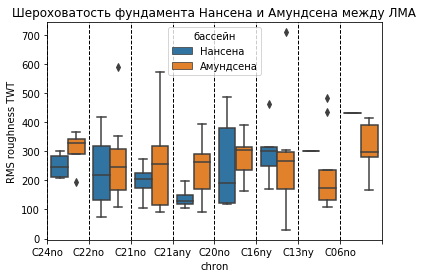

In [357]:
nansen=[i for i in RMS.columns if '00' in i]
amundsen=[i for i in RMS.columns if ('02' in i) or ('03' in i)]
a=RMS.drop(['start','end','age'],axis=1).unstack()

lines=[i[0] for i in a.index.tolist()]
c=[]
for i in range(17):
    c.extend(list(chrons.keys())[1:])
RMS_for_sns=pd.DataFrame(data=list(zip(lines,list(a.values),c[::-1])),columns=['line','RMS roughness TWT','chron'])
RMS_for_sns['бассейн']=RMS_for_sns['line'].apply(lambda x: 'Нансена' if x in nansen else 'Амундсена')
sns.boxplot(data=RMS_for_sns,x='chron',y='RMS roughness TWT',hue='бассейн')
plt.title('Шероховатость фундамента Нансена и Амундсена между ЛМА')
plt.xticks([i-0.5 for i in range(9)],RMS.age)
# plt.xlim(1.5,6.5)
for xc in [i-0.5 for i in range(8)]:
    plt.axvline(x=xc, color='k', linestyle='--',lw=1)
plt.savefig('RMS_rough.jpg',dpi=450)    
plt.show()

# a=RMS[nansen].unstack()
# lines=[i[0] for i in a.index.tolist()]
# c=[]
# for i in range(17):
#     c.extend(list(chrons.keys())[1:])
# RMS_for_sns=pd.DataFrame(data=list(zip(lines,list(a.values),c)),columns=['line','RMS roughness TWT','chron'])

# sns.boxplot(data=RMS_for_sns,x='chron',y='RMS roughness TWT',color='white',width=0.4)
# plt.xticks([i-0.5 for i in range(9)],RMS.age)
# for xc in [i-0.5 for i in range(8)]:
#     plt.axvline(x=xc, color='k', linestyle='--',lw=1)
# plt.savefig('RMS_rough.jpg',dpi=450)    
# plt.show()

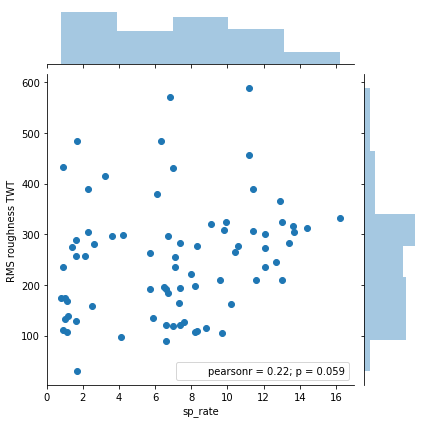

In [364]:
def calc_rate(d):
    return(round(d['dist']/(chrons[d['start']]-chrons[d['end']])/10,1))
chrons_ages=pd.DataFrame(data=chrons,index=range(2)).transpose()
chrons_ages[1]=chrons_ages[0].shift(-1)
chrons_ages['time']=(chrons_ages[1]-chrons_ages[0])
distes=pd.DataFrame(distances,columns=['line','start','end','dist'])
distes['sp_rate']=distes.apply(calc_rate,axis=1)
rough_rate=pd.merge(distes,RMS_for_sns,left_on=['line','start'],right_on=['line','chron'])
sns.jointplot('sp_rate','RMS roughness TWT',data=rough_rate)

In [352]:
def calc_distance(name):
    one_line=result[result['line']==name]
    chrons_on_line=one_line[one_line['name'].notnull()].name.values
    if chrons[chrons_on_line[0]]<chrons[chrons_on_line[-1]]:
        one_line=one_line.reindex(index=one_line.index[::-1])
        one_line.index=range(len(one_line))
        chrons_on_line=one_line[one_line['name'].notnull()].name.values
    print(name,chrons_on_line)
    index=one_line[one_line['name'].notnull()].name.index
    min_chron=one_line[one_line['name'].notnull()].index.min()
    max_chron=one_line[one_line['name'].notnull()].index.max()
    one_line=one_line.loc[min_chron:max_chron]
    one_line.index=range(len(one_line))
    index=one_line[one_line['name'].notnull()].name.index
    new_depth=[]
    regression=[]
    space_on_start=5398-chrons[chrons_on_line[0]]
    dists=[]
    for i in range(len(chrons_on_line)-1):
        start=one_line[one_line['name']==chrons_on_line[i]].index[0]
        end=one_line[one_line['name']==chrons_on_line[i+1]].index[0]
        distance=(abs(one_line.loc[start,'x']-one_line.loc[end,'x'])**2+abs(one_line.loc[start,'y']-one_line.loc[end,'y'])**2)**0.5
        print([name,chrons_on_line[i+1],distance])
        dists.append([name,chrons_on_line[i],chrons_on_line[i+1],distance])
    return(dists)
distances=[]
for i in result.line.unique():
    if i not in ['Arc11005_04','Arc11006_02','Arc11005_06']:
        distances.extend(calc_distance(i))

Arc11003 ['C24no' 'C21no' 'C21any' 'C20no' 'C13ny']
['Arc11003', 'C21no', 80357.3257506103]
['Arc11003', 'C21any', 15483.971425974685]
['Arc11003', 'C20no', 14911.602142928832]
['Arc11003', 'C13ny', 62622.85590049771]
Arc11035 ['C21no' 'C20no' 'C16ny']
['Arc11035', 'C20no', 53000.596075268775]
['Arc11035', 'C16ny', 24136.456481184257]
Arc11005 ['C24no' 'C21no' 'C21any' 'C20no' 'C13ny']
['Arc11005', 'C21no', 86396.64836810507]
['Arc11005', 'C21any', 13333.37831493953]
['Arc11005', 'C20no', 16944.852332685]
['Arc11005', 'C13ny', 58754.11059758886]
Arc11006 ['C24no' 'C21no' 'C21any' 'C20no' 'C13ny']
['Arc11006', 'C21no', 70344.9278818743]
['Arc11006', 'C21any', 15702.115182382255]
['Arc11006', 'C20no', 18750.553174714627]
['Arc11006', 'C13ny', 71918.08952267992]
Arc11006_10 ['C20no' 'C13ny' 'C06no' 'C05ny']
['Arc11006_10', 'C13ny', 68117.8465077574]
['Arc11006_10', 'C06no', 56857.48958590771]
['Arc11006_10', 'C05ny', 69878.41767772357]
Arc11024 ['C20no' 'C16ny' 'C13ny' 'C06no' 'C05ny']
['

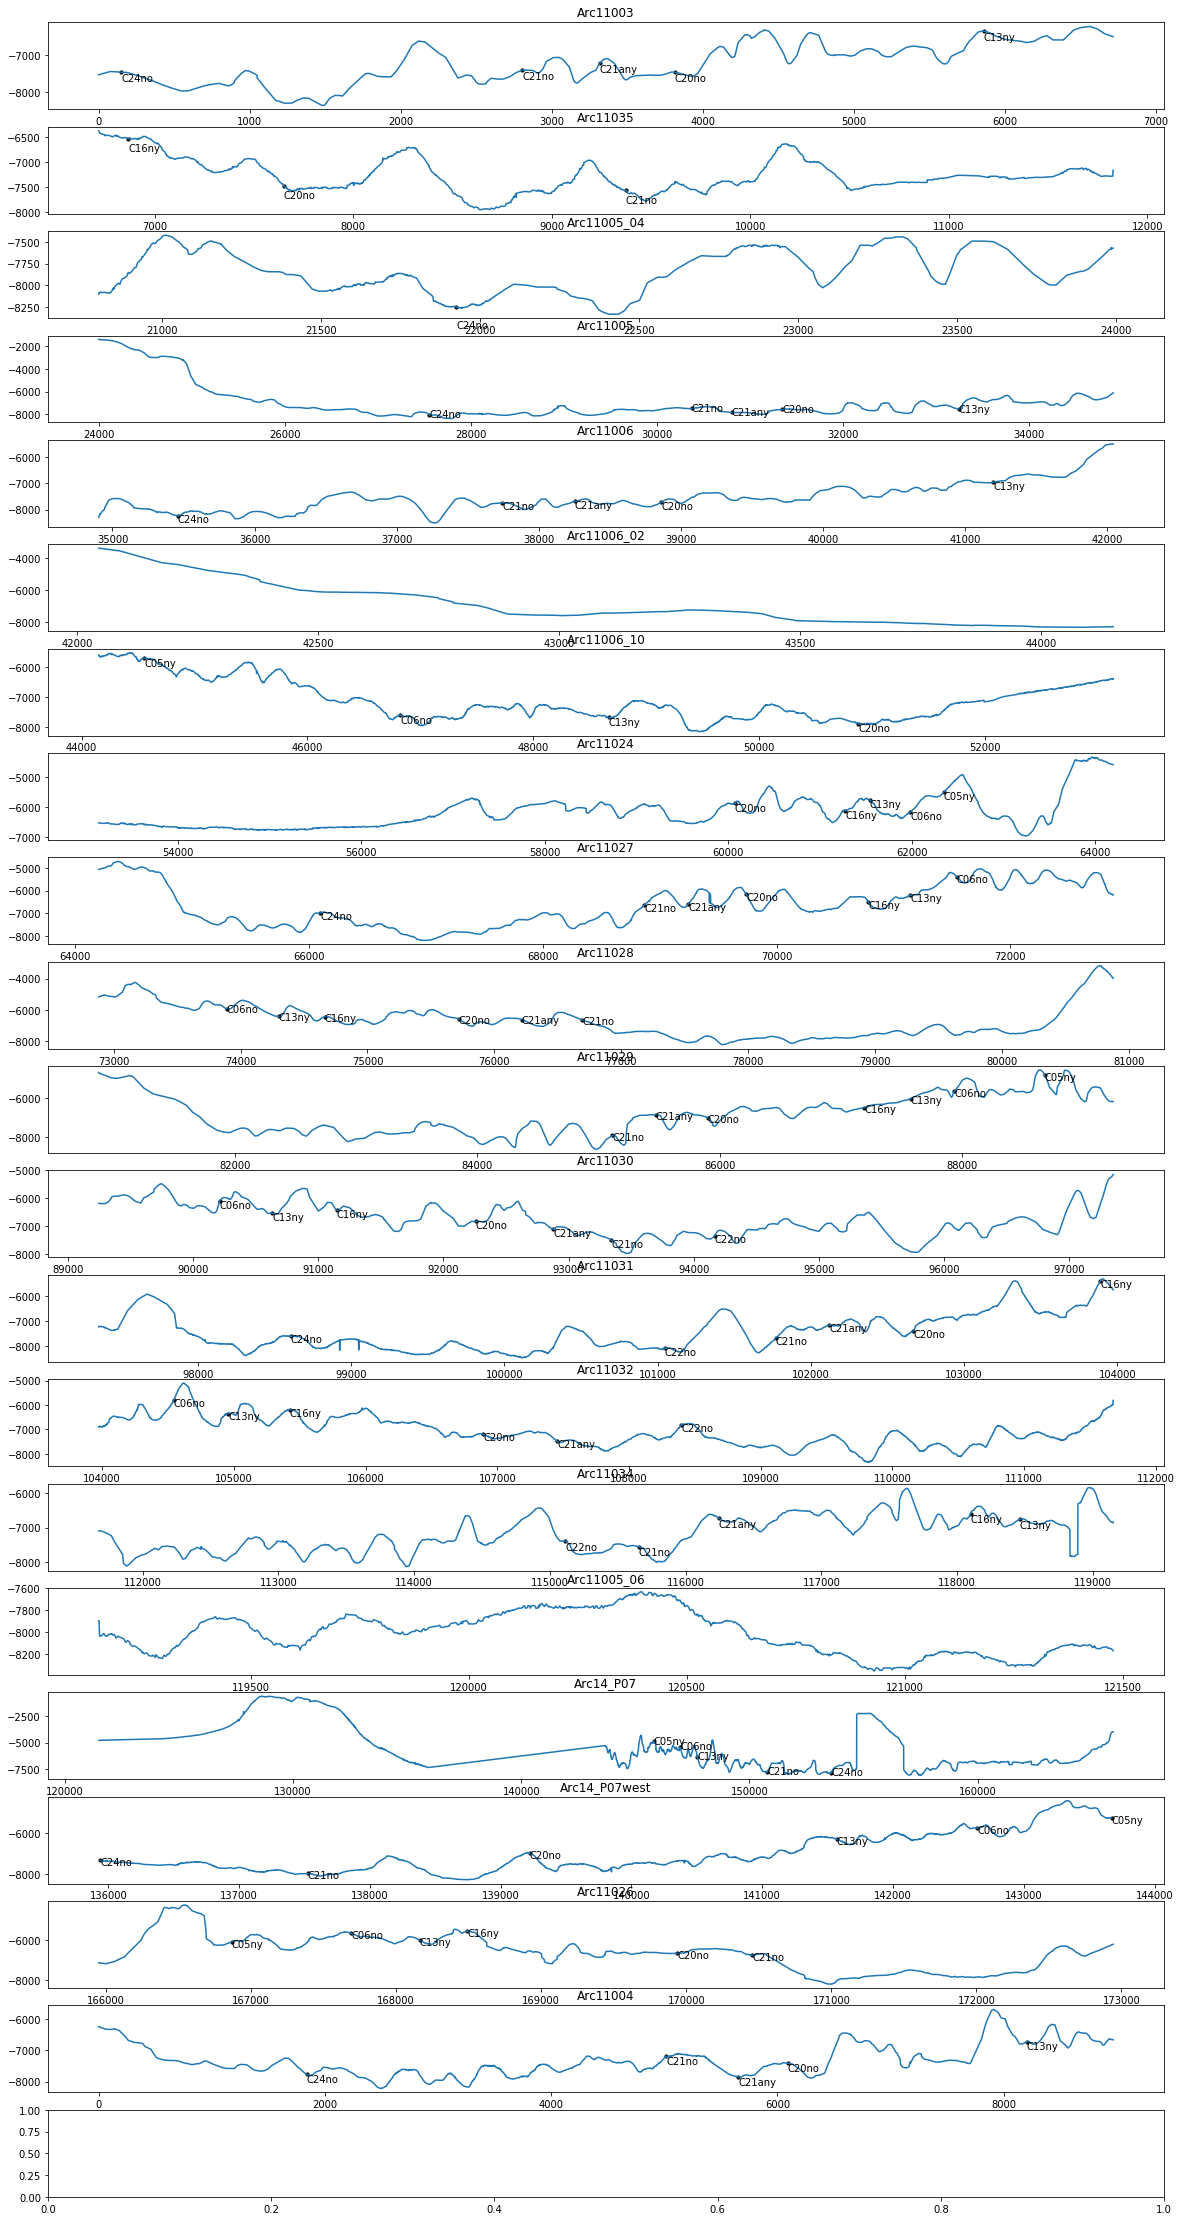

In [321]:

f, axarr = plt.subplots(21,1, figsize=(20,40))
q=0
for j in result.line.unique():
    one_line=result[result['line']==j]
    axarr[q].plot(-one_line['depth_x'])
    axarr[q].set_title(j) 
    for i in one_line[one_line.name.notnull()==True].index:
        axarr[q].text(x=i,y=-one_line.loc[i,'depth_x']-250,s=one_line.loc[i,'name'])
        axarr[q].scatter(x=i,y=-one_line.loc[i,'depth_x'],s=10,c='black')
    q+=1
plt.savefig('result.svg')    
plt.show()

In [346]:
velocities=pd.read

,res,Arc11003,Arc11035,Arc11005,Arc11006,Arc11006_10,Arc11024,Arc11027,Arc11028,Arc11029,Arc11030,Arc11031,Arc11032,Arc11034,Arc14_P07,Arc14_P07west,Arc11026,Arc11004
0,NaN,-417.689446,NaN,-151.595853,-39.013312,NaN,NaN,-601.495384,NaN,NaN,NaN,-501.515827,NaN,NaN,256.076293,-671.557148,NaN,-380.111672
1,NaN,-393.986555,NaN,114.869704,181.853275,NaN,NaN,-444.954092,NaN,NaN,NaN,-756.403959,NaN,NaN,290.899391,-903.115410,NaN,-99.779385
2,NaN,-398.978742,NaN,59.861284,121.272283,NaN,NaN,-497.598320,NaN,NaN,NaN,-678.778460,NaN,NaN,299.530232,-830.622872,NaN,-168.093727
3,NaN,-393.610024,NaN,113.400690,152.615569,NaN,NaN,-473.122864,NaN,NaN,NaN,-710.921814,NaN,NaN,317.743079,-870.226985,NaN,-116.603100
4,NaN,-394.947064,NaN,94.968597,137.746575,NaN,NaN,-499.102581,NaN,NaN,NaN,-689.157525,NaN,NaN,311.881217,-831.114433,NaN,-141.234455
5,NaN,-391.259861,NaN,126.627708,146.911737,NaN,NaN,-490.114841,NaN,NaN,NaN,-711.660089,NaN,NaN,317.157790,-841.897962,NaN,-109.885358
6,NaN,-391.630067,NaN,105.171887,111.831617,NaN,NaN,-512.325191,NaN,NaN,NaN,-687.756315,NaN,NaN,324.541812,-812.447516,NaN,-122.550249
7,NaN,-388.550016,NaN,118.499589,101.090339,NaN,NaN,-509.802339,NaN,NaN,NaN,-703.129330,NaN,NaN,324.862091,-830.261761,NaN,-101.337839
8,NaN,-388.570766,NaN,101.432236,81.945554,NaN,NaN,-525.143002,NaN,NaN,NaN,-674.302594,NaN,NaN,329.675194,-814.407369,NaN,-123.719358
9,NaN,-384.904925,NaN,107.042478,74.521883,NaN,NaN,-510.558525,NaN,NaN,NaN,-693.853326,NaN,NaN,330.782293,-814.396425,NaN,-119.335749


In [320]:
result_DB['Arc11003']

0      -417.748882
1      -394.041034
2      -399.051258
3      -393.669386
4      -395.024851
5      -391.324578
6      -391.712746
7      -388.620709
8      -388.656758
9      -385.015790
10     -380.926257
11     -374.847508
12     -370.536691
13     -364.586683
14     -360.166465
15     -354.311902
16     -349.807898
17     -344.027217
18     -339.457801
19     -333.735220
20     -329.114110
21     -323.437485
22     -318.775747
23     -313.134492
24     -308.443129
25     -302.824330
26     -298.113000
27     -291.791919
28     -285.809346
29     -279.151879
           ...    
5368           NaN
5369           NaN
5370           NaN
5371           NaN
5372           NaN
5373           NaN
5374           NaN
5375           NaN
5376           NaN
5377           NaN
5378           NaN
5379           NaN
5380           NaN
5381           NaN
5382           NaN
5383           NaN
5384           NaN
5385           NaN
5386           NaN
5387           NaN
5388           NaN
5389        

In [8]:
vel=pd.read_excel('029 VEL.xlsx')

In [6]:
vel.groupby(['x','y'])['int vel']


,x,y,twt,int vel,line,sp
0,585928.926,670049.920,0,1450.1,ARC_027,1001
1,585928.926,670049.920,30,1450.4,ARC_027,1001
2,585928.926,670049.920,60,1450.8,ARC_027,1001
3,585928.926,670049.920,90,1451.2,ARC_027,1001
4,585928.926,670049.920,120,1451.6,ARC_027,1001
5,585928.926,670049.920,150,1452.0,ARC_027,1001
6,585928.926,670049.920,180,1452.4,ARC_027,1001
7,585928.926,670049.920,210,1452.8,ARC_027,1001
8,585928.926,670049.920,240,1453.1,ARC_027,1001
9,585928.926,670049.920,270,1453.5,ARC_027,1001


In [10]:
result

,x,y,line,depth_x,name
0,517804.31,-564967.66,Arc11003,7536.000,NaN
1,517776.67,-564953.96,Arc11003,7534.827,NaN
2,517749.03,-564940.27,Arc11003,7533.653,NaN
3,517721.39,-564926.58,Arc11003,7532.480,NaN
4,517693.75,-564912.88,Arc11003,7531.307,NaN
5,517666.11,-564899.19,Arc11003,7530.133,NaN
6,517638.47,-564885.50,Arc11003,7528.960,NaN
7,517610.83,-564871.80,Arc11003,7527.787,NaN
8,517583.19,-564858.11,Arc11003,7526.613,NaN
9,517555.55,-564844.42,Arc11003,7525.440,NaN
